In [1]:
# import dataset
import pandas as pd
import numpy as np

df = pd.read_csv('air_quality_pollutants_combined_dataset.csv')
df

C:\Users\kapil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,date,acute_bronchiolitis_syndromic,acute_respiratory_illness,influenza_like_syndromic,scarlet_fever_syndromic,black_carbon,blue_particulate_matter,green_particulate_matter,infra_red_particulate_matter,nitric_dioxide,nitric_oxide,nitrogen_oxides_as_nitrogen_dioxide,Ozone,PM10,PM2.5,red_particulate_matter,UV_particulate_matter_370nm,yellow_particulate_matter_590nm
0,09-06-2024,2.0,176.0,2.0,3.0,0.403,0.470,0.447,0.423,8.000,3.786,13.571,59.444,8.200,4.125,0.410,0.467,0.430
1,10-06-2024,7.0,166.0,2.0,0.0,0.337,0.373,0.353,0.347,8.500,4.214,14.929,60.900,6.100,3.000,0.327,0.363,0.347
2,11-06-2024,6.0,155.0,0.0,0.0,0.480,0.530,0.507,0.487,12.143,5.214,19.929,60.500,8.700,4.250,0.480,0.517,0.503
3,12-06-2024,2.0,157.0,0.0,0.0,0.663,0.753,0.717,0.680,14.500,6.000,23.786,64.500,10.300,4.875,0.670,0.747,0.703
4,13-06-2024,3.0,137.0,0.0,0.0,0.667,0.733,0.703,0.670,13.929,7.643,25.500,59.300,10.400,4.625,0.670,0.710,0.693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,04-06-2025,10.0,144.0,0.0,0.0,0.423,0.457,0.433,0.430,9.250,4.500,15.938,70.455,11.643,5.267,0.417,0.443,0.430
361,05-06-2025,9.0,149.0,3.0,1.0,0.600,0.910,0.630,0.617,11.812,5.688,20.562,58.182,4.643,2.267,0.603,0.860,0.620
362,06-06-2025,6.0,137.0,1.0,0.0,0.155,0.599,0.170,0.170,10.312,4.938,18.000,56.818,6.429,2.933,0.155,0.641,0.165
363,07-06-2025,5.0,144.0,1.0,0.0,0.230,0.300,0.245,0.235,10.062,4.250,16.562,56.636,5.214,2.533,0.230,0.275,0.235


In [2]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

health_columns = ['acute_bronchiolitis_syndromic', 'acute_respiratory_illness', 
                 'influenza_like_syndromic', 'scarlet_fever_syndromic']
pollutant_columns = ['black_carbon', 'blue_particulate_matter', 'green_particulate_matter', 
                     'infra_red_particulate_matter', 'nitric_dioxide', 'nitric_oxide', 
                     'nitrogen_oxides_as_nitrogen_dioxide', 'Ozone', 'PM10', 'PM2.5', 
                     'red_particulate_matter', 'UV_particulate_matter_370nm', 
                     'yellow_particulate_matter_590nm']

In [3]:
import statsmodels.api as sm

# Convert date to datetime and sort just to be safe
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values('date')

# Define maximum lag
max_lag = 30

# Generate lagged features for nitric_dioxide
for lag in range(0, max_lag + 1):
    df[f'nitric_dioxide_lag_{lag}'] = df['nitric_dioxide'].shift(lag)

# Drop rows with NaNs due to lagging
lagged_df = df.dropna(subset=[f'nitric_dioxide_lag_{lag}' for lag in range(0, max_lag + 1)])

# Prepare X (lagged NO2 values) and y (acute_respiratory_illness)
X = lagged_df[[f'nitric_dioxide_lag_{lag}' for lag in range(0, max_lag + 1)]]
y = lagged_df['acute_respiratory_illness']

# Add constant to X for regression
X = sm.add_constant(X)

# Fit OLS model (Distributed Lag Model)
model = sm.OLS(y, X).fit()

# Extract coefficients (excluding constant)
coeffs = model.params.drop('const')

# Display summary and coefficients
model_summary = model.summary()
coeffs_sorted = coeffs.sort_values(ascending=False)

model_summary, coeffs_sorted.head(10)  # Top 10 lags with highest effect


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                 OLS Regression Results                               
 Dep. Variable:     acute_respiratory_illness   R-squared:                       0.383
 Model:                                   OLS   Adj. R-squared:                  0.320
 Method:                        Least Squares   F-statistic:                     6.069
 Date:                       Sun, 10 Aug 2025   Prob (F-statistic):           4.49e-18
 Time:                               17:39:06   Log-Likelihood:                -1842.8
 No. Observations:                        335   AIC:                             3750.
 Df Residuals:                            303   BIC:                             3872.
 Df Model:                                 31                                         
 Covariance Type:                   nonrobust                                         
                             coef    std err          t      P>|t|      [0.025  

In [4]:
# Create Almon lag variables (degree 2 polynomial terms)
# Z1 = sum(i * X_t-i), Z2 = sum(i^2 * X_t-i)
lags = range(max_lag + 1)
lagged_data = df[[f'nitric_dioxide_lag_{lag}' for lag in lags]].dropna()

Z1 = sum(i * lagged_data[f'nitric_dioxide_lag_{i}'] for i in lags)
Z2 = sum((i**2) * lagged_data[f'nitric_dioxide_lag_{i}'] for i in lags)

# Align y accordingly
y_almon_poly = df['acute_respiratory_illness'].iloc[max_lag:]

# Combine into design matrix
X_almon_poly = pd.DataFrame({'Z1': Z1, 'Z2': Z2})
X_almon_poly = sm.add_constant(X_almon_poly)

# Fit the model
model_almon_poly = sm.OLS(y_almon_poly, X_almon_poly).fit()

# Output model summary and coefficients
model_almon_poly.summary(), model_almon_poly.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                 OLS Regression Results                               
 Dep. Variable:     acute_respiratory_illness   R-squared:                       0.356
 Model:                                   OLS   Adj. R-squared:                  0.352
 Method:                        Least Squares   F-statistic:                     91.79
 Date:                       Sun, 10 Aug 2025   Prob (F-statistic):           1.86e-32
 Time:                               17:39:07   Log-Likelihood:                -1850.0
 No. Observations:                        335   AIC:                             3706.
 Df Residuals:                            332   BIC:                             3717.
 Df Model:                                  2                                         
 Covariance Type:                   nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]


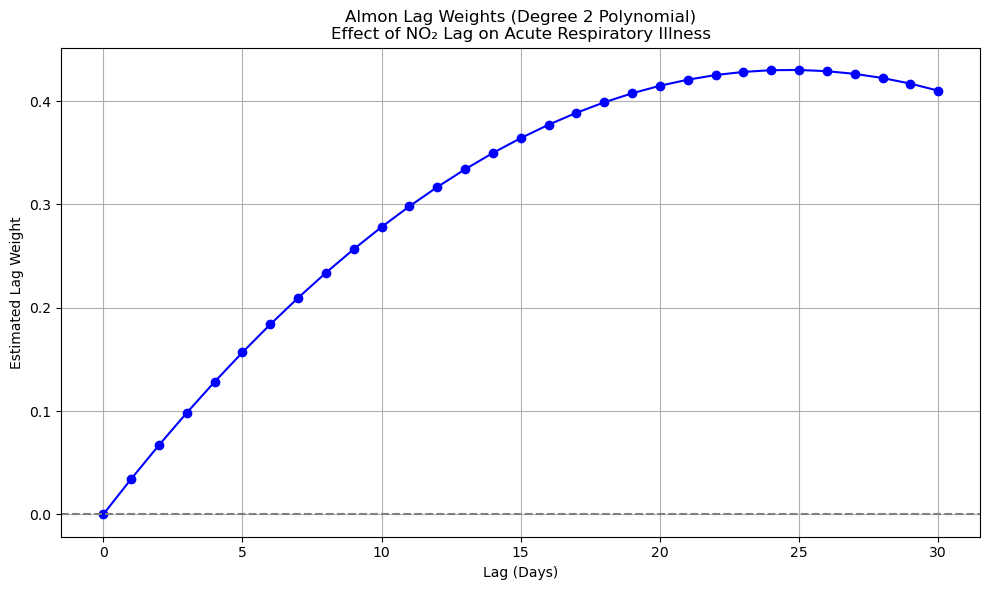

In [5]:
import matplotlib.pyplot as plt

# Generate lag weights using the Almon polynomial: w_i = a * i + b * i^2
lags = np.arange(0, max_lag + 1)
a = model_almon_poly.params['Z1']
b = model_almon_poly.params['Z2']
weights = a * lags + b * (lags ** 2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lags, weights, marker='o', linestyle='-', color='blue')
plt.title("Almon Lag Weights (Degree 2 Polynomial)\nEffect of NO₂ Lag on Acute Respiratory Illness")
plt.xlabel("Lag (Days)")
plt.ylabel("Estimated Lag Weight")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

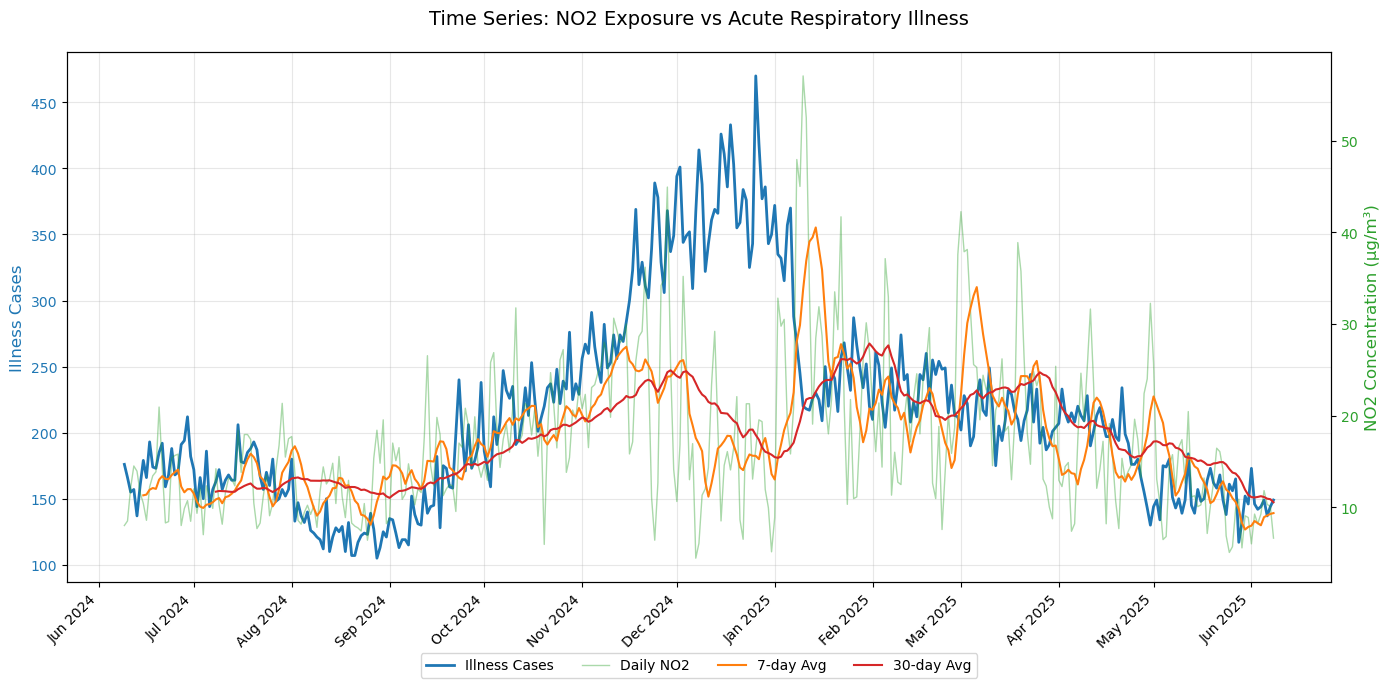

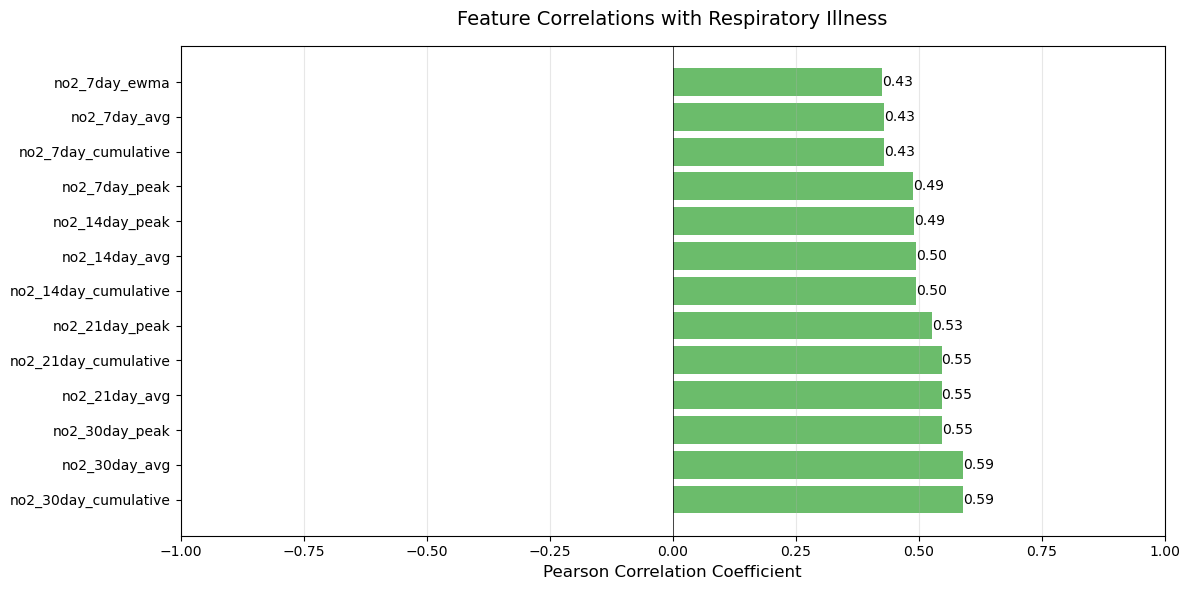


=== TIME SERIES FEATURE ANALYSIS ===

Feature                   | Correlation | Interpretation 
------------------------------------------------------------
no2_30day_cumulative      |      0.590 | Strong Positive
no2_30day_avg             |      0.590 | Strong Positive
no2_30day_peak            |      0.548 | Strong Positive
no2_21day_avg             |      0.547 | Strong Positive
no2_21day_cumulative      |      0.547 | Strong Positive
no2_21day_peak            |      0.528 | Strong Positive
no2_14day_cumulative      |      0.496 | Moderate Positive
no2_14day_avg             |      0.496 | Moderate Positive
no2_14day_peak            |      0.491 | Moderate Positive
no2_7day_peak             |      0.490 | Moderate Positive
no2_7day_cumulative       |      0.430 | Moderate Positive
no2_7day_avg              |      0.430 | Moderate Positive
no2_7day_ewma             |      0.427 | Moderate Positive

Strongest positive relationship: no2_30day_cumulative (r = 0.590)
Strongest negative r

In [7]:
def create_time_series_features(df, x_col, windows=[7, 14, 21, 30], ewma_span=7):
    """
    Create time series features: rolling averages, EWMA, cumulative exposure, and peak exposure.
    Returns DataFrame with new features and dictionary of correlations.
    """
    df_features = df.copy()
    correlations = {}
    
    # Rolling averages
    for window in windows:
        col_name = f'no2_{window}day_avg'
        df_features[col_name] = df[x_col].rolling(window=window, min_periods=window).mean()
        valid_idx = df_features[col_name].dropna().index
        corr = df_features['acute_respiratory_illness'].loc[valid_idx].corr(df_features[col_name].loc[valid_idx])
        correlations[col_name] = corr
    
    # Exponentially weighted moving average
    col_name = 'no2_7day_ewma'
    df_features[col_name] = df[x_col].ewm(span=ewma_span, adjust=False).mean()
    corr = df_features['acute_respiratory_illness'].corr(df_features[col_name])
    correlations[col_name] = corr
    
    # Cumulative exposure
    for window in windows:
        col_name = f'no2_{window}day_cumulative'
        df_features[col_name] = df[x_col].rolling(window=window, min_periods=window).sum()
        valid_idx = df_features[col_name].dropna().index
        corr = df_features['acute_respiratory_illness'].loc[valid_idx].corr(df_features[col_name].loc[valid_idx])
        correlations[col_name] = corr
    
    # Peak exposure
    for window in windows:
        col_name = f'no2_{window}day_peak'
        df_features[col_name] = df[x_col].rolling(window=window, min_periods=window).max()
        valid_idx = df_features[col_name].dropna().index
        corr = df_features['acute_respiratory_illness'].loc[valid_idx].corr(df_features[col_name].loc[valid_idx])
        correlations[col_name] = corr
    
    return df_features, correlations

# Create features and compute correlations
df_features, feature_correlations = create_time_series_features(df, 'nitric_dioxide')

import matplotlib.dates as mdates

# Ensure datetime index
df_features = df_features.set_index('date')

plt.figure(figsize=(14, 7))
plt.title('Time Series: NO2 Exposure vs Acute Respiratory Illness', pad=20, fontsize=14)

# Primary axis
ax1 = plt.gca()
ax1.plot(df_features.index, df_features['acute_respiratory_illness'], 
         label='Illness Cases', color='tab:blue', linewidth=2)
ax1.set_ylabel('Illness Cases', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

# Format x-axis as month name + year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2023
ax1.xaxis.set_major_locator(mdates.MonthLocator())            # Monthly ticks
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Secondary axis
ax2 = ax1.twinx()
ax2.plot(df_features.index, df_features['nitric_dioxide'], 
         label='Daily NO2', color='tab:green', alpha=0.4, linewidth=1)
ax2.plot(df_features.index, df_features['no2_7day_avg'], 
         label='7-day Avg', color='tab:orange', linewidth=1.5)
ax2.plot(df_features.index, df_features['no2_30day_avg'], 
         label='30-day Avg', color='tab:red', linewidth=1.5)
ax2.set_ylabel('NO2 Concentration (µg/m³)', color='tab:green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:green')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4)

plt.tight_layout()
plt.show()


# --- Plot 2: Feature Correlations ---
plt.figure(figsize=(12, 6))
sorted_corrs = dict(sorted(feature_correlations.items(), 
                         key=lambda item: abs(item[1]), 
                         reverse=True))

colors = ['tab:green' if x > 0 else 'tab:red' for x in sorted_corrs.values()]
plt.barh(list(sorted_corrs.keys()), list(sorted_corrs.values()), color=colors, alpha=0.7)
plt.title('Feature Correlations with Respiratory Illness', pad=15, fontsize=14)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.xlim(-1, 1)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, axis='x', alpha=0.3)

# Add correlation values on bars
for i, (k, v) in enumerate(sorted_corrs.items()):
    plt.text(v, i, f'{v:.2f}', 
             ha='left' if v > 0 else 'right', 
             va='center', 
             color='black',
             fontsize=10)

plt.tight_layout()
plt.show()

# --- Print Summary Statistics ---
print("\n=== TIME SERIES FEATURE ANALYSIS ===")
print(f"\n{'Feature':<25} | {'Correlation':>10} | {'Interpretation':<15}")
print("-"*60)
for feature, corr in sorted_corrs.items():
    strength = "Weak" if abs(corr) < 0.3 else "Moderate" if abs(corr) < 0.5 else "Strong"
    direction = "Positive" if corr > 0 else "Negative"
    print(f"{feature:<25} | {corr:>10.3f} | {f'{strength} {direction}':<15}")

# Show strongest relationships
strongest_pos = max(feature_correlations.items(), key=lambda x: x[1])
strongest_neg = min(feature_correlations.items(), key=lambda x: x[1])
print(f"\nStrongest positive relationship: {strongest_pos[0]} (r = {strongest_pos[1]:.3f})")
print(f"Strongest negative relationship: {strongest_neg[0]} (r = {strongest_neg[1]:.3f})")